# MNIST CNN Classifier
Adapted from the [mnist_cnn keras example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) pointed to from the [AWS tutorial on containers](https://aws.amazon.com/getting-started/tutorials/train-deep-learning-model-aws-ec2-containers/):
```
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
```

# Setup libraries and parameters

In [70]:
import pdb
import time
import os.path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [26]:
# Training settings
class Args:
    batch_size=128
    test_batch_size=1000
    epochs=12
    lr=0.01
    momentum=0.5
    no_cuda=False
    seed=1
    log_interval=117
    save_checkpoints=True
    load_checkpoint=None #'mnist_012.pth'

args = Args

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Network definition
Adapted from this portion of the Keras example model
```
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
```
A few modifications:
* I changed the first layer to output 8 channels instead of 32, with the rationale being that a 3x3 kernel only spans 9 DOF. Any channels above 9 would start to become linearly dependent, but the nonlinearity after them might allow them to learn more?
* I added batch normalization after the first two convolutional layers because...well...everyone says they are helpful

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        # weights = 1x8x3x3 = 72
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 64, 3, 1)
        # weights = 8x64x3x3 = 4,608
        self.drop1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(12*12*64, 128)
        # weights = 12x12x64x128 = 1,179,648
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        # weights = 128 x 10 = 1280

    def forward(self, x):
        # layer size 28x28x1 = 784
        x = F.relu(self.bn1(self.conv1(x)))
        # layer size 26x26x8 = 5,408
        # perf = 21,632 outputs x 288 kernel entries = 6,230,016 mul adds
        x = F.relu(self.bn2(self.conv2(x)))
        # layer size 24x24x64 = 36,864
        # perf = 36,864 outputs x 589,824 kernel entries = 21,743,271,936 mul adds
        x = F.max_pool2d(x, 2, 2)
        # layer size 12x12x64 = 9216
        x = self.drop1(x)
        x = x.view(-1, 12*12*64)
        # layer size 1x12*12*64 = 9216
        x = F.relu(self.fc1(x))
        # layer size 1x128
        # perf = 1,179,648 mul adds
        x = self.drop2(x)
        x = self.fc2(x)
        # layer size 1x10
        # perf = 1280 mul adds
        return F.log_softmax(x, dim=1)

In [28]:
model = Net().to(device)

# Define the optimizer and loss criterion
I initially ran with SGD, but am now trying Adadelta. I haven't explicitly looked at what the loss is. Here is how Keras was set up:
```
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
```
I've switched to CrossEntropyLoss. I haven't validated that [Keras](https://keras.io/losses/) and [PyTorch](https://pytorch.org/docs/stable/nn.html#crossentropyloss) implement it the same.

In [29]:
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
optimizer = optim.Adadelta(model.parameters())
loss_criterion = nn.CrossEntropyLoss(reduction='sum')

# Print out parameter sizes

In [30]:
def print_model_size(model):
    total_model_size = 0
    print("Model's state_dict:")
    # print out size of each set of parameter
    for param_tensor in model.state_dict():
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue
            
        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))

    # print out total
    print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [31]:
print_model_size(model)

Model's state_dict:
conv1.weight     torch.Size([8, 1, 3, 3])   : 8 x 9 = 72
conv1.bias       torch.Size([8])            : 8
bn1.weight       torch.Size([8])            : 8
bn1.bias         torch.Size([8])            : 8
bn1.running_mean torch.Size([8])            : 8
bn1.running_var  torch.Size([8])            : 8
conv2.weight     torch.Size([64, 8, 3, 3])  : 64 x 72 = 4,608
conv2.bias       torch.Size([64])           : 64
bn2.weight       torch.Size([64])           : 64
bn2.bias         torch.Size([64])           : 64
bn2.running_mean torch.Size([64])           : 64
bn2.running_var  torch.Size([64])           : 64
fc1.weight       torch.Size([128, 9216])    : 128 x 9216 = 1,179,648
fc1.bias         torch.Size([128])          : 128
fc2.weight       torch.Size([10, 128])      : 10 x 128 = 1,280
fc2.bias         torch.Size([10])           : 10

Total Model Size                            : 1,186,106


# DataLoaders|
Wrap dataset downloaders in a DataLoader class

In [32]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, **kwargs)

# Define the test and training functions

In [33]:
def init(model):
    for param_tensor in model.state_dict():
        nn.init.xavier_uniform_(model.state_dict()[param_tensor]), gain=nn.init.calculate_gain('relu'))
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue
            
        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))

SyntaxError: invalid syntax (<ipython-input-33-ef9a57cd8df2>, line 3)

In [39]:
def train(args, model, device, train_loader, optimizer, epoch):
    # Set model to be in training mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{:5}/{} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/len(data)))

In [40]:
def test(args, model, device, test_loader):
    # Set model to be in testing mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [41]:
def run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch):
    train_start = time.perf_counter()
    train(args, model, device, train_loader, optimizer, epoch)
    train_end = time.perf_counter()
    train_delta = train_end - train_start

    test_start = time.perf_counter()
    test(args, model, device, test_loader)
    test_end = time.perf_counter()
    test_delta = test_end - test_start
    
    print("Training took {:.1f}s.".format(train_delta))
    print("Testing took {:.1f}s.\n".format(test_delta))   

# Checkpointing Logic
This implementation is based on the [PyTorch reference](https://pytorch.org/tutorials/beginner/saving_loading_models.html) 

In [42]:
def save_checkpoint(epoch, filepath='.', prefix='mnist_'):
    checkpoint = {'epoch' : epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict' : optimizer.state_dict(),
                  'loss_criterion' : loss_criterion}
    torch.save(checkpoint, os.path.join(filepath, '{}{:03}.pth'.format(prefix, epoch)))
    
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_criterion = checkpoint['loss_criterion']
    for parameter in model.parameters():
        parameter.requires_grad = False

# Train (or load) the network

In [43]:
if args.load_checkpoint:
    load_checkpoint(args.load_checkpoint)
    test(args, model, device, test_loader)
else:
    for epoch in range(1, args.epochs + 1):
        run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch)
        if args.save_checkpoints:
            save_checkpoint(epoch)

Train Epoch: 1 [    0/60000 (  0%)]	Loss: 2.336345
Train Epoch: 1 [14976/60000 ( 25%)]	Loss: 0.341401
Train Epoch: 1 [29952/60000 ( 50%)]	Loss: 0.318869
Train Epoch: 1 [44928/60000 ( 75%)]	Loss: 0.115886
Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.094688

Test set: Average loss: 0.0606, Accuracy: 9811/10000 (98%)
Training took 117.9s.
Testing took 10.2s.

Train Epoch: 2 [    0/60000 (  0%)]	Loss: 0.208762
Train Epoch: 2 [14976/60000 ( 25%)]	Loss: 0.152320
Train Epoch: 2 [29952/60000 ( 50%)]	Loss: 0.213651
Train Epoch: 2 [44928/60000 ( 75%)]	Loss: 0.087772
Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.016735

Test set: Average loss: 0.0530, Accuracy: 9837/10000 (98%)
Training took 122.1s.
Testing took 10.5s.

Train Epoch: 3 [    0/60000 (  0%)]	Loss: 0.097726
Train Epoch: 3 [14976/60000 ( 25%)]	Loss: 0.030098
Train Epoch: 3 [29952/60000 ( 50%)]	Loss: 0.077375
Train Epoch: 3 [44928/60000 ( 75%)]	Loss: 0.163559
Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.031697

Test set: Average loss: 0.04

# Visualization Code

In [55]:
#plot some of the test data
def plot_data(dataset, entries):
    shp = np.shape(entries)
    width = shp[0]
    if len(shp) > 1:
        height = shp[1]
    else:
        height = 1
        
    entries_lst = np.reshape(entries,(width*height))
    
    targets = list(map(lambda idx: dataset.__getitem__(idx)[1], entries_lst))
    print('Labels: {}'.format(np.reshape(targets, shp)))

    fig, ax = plt.subplots(height,width,dpi=100)
    for row in range(0,height):
        if height>1:
            row_ax = ax[row]
        else:
            row_ax = ax            
        for col in range(0,width):
            idx = col + width*row
            im = row_ax[col].imshow(dataset.__getitem__(entries_lst[idx])[0].view(28,28), cmap='binary')
            row_ax[col].axis('off')
    plt.show()

## Test data

Labels: [[7 2 1 0 4]
 [1 4 9 5 9]
 [0 6 9 0 1]
 [5 9 7 3 4]
 [9 6 6 5 4]]


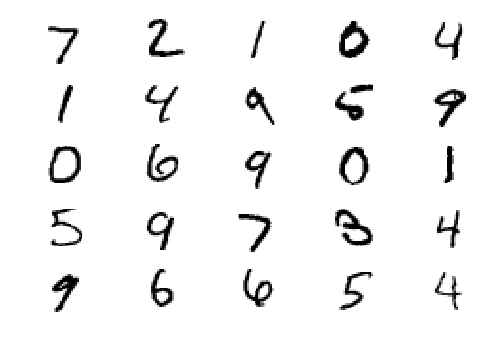

In [56]:
dim = 5
entries = np.reshape(range(0,dim*dim),(dim,dim))
plot_data(test_loader.dataset,entries)

## Training data

Labels: [[5 0 4 1 9]
 [2 1 3 1 4]
 [3 5 3 6 1]
 [7 2 8 6 9]
 [4 0 9 1 1]]


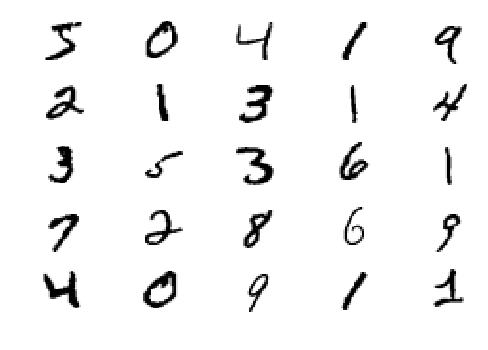

In [57]:
#plot some of the training data
entries = np.reshape(range(0,dim*dim),(dim,dim))
plot_data(train_loader.dataset, entries)

## Get Failures

In [58]:
def get_failures(model, device, test_loader):
    model.eval()

    batch_offset = 0
    failure_indices = []
    target_all = torch.zeros((0),dtype=torch.long)
    output_all = torch.zeros((0,10))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            target_all = torch.cat((target_all, target))
            output_all = torch.cat((output_all, output))

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            idx = np.where(pred.ne(target.view_as(pred)))[0]
            failure_indices += list(idx + batch_offset)
            
            batch_offset += pred.size(0)
    return np.array(failure_indices), output_all, target_all

In [59]:
failure_indices, output_all, target_all = get_failures(model, device, test_loader)

## Plot Confusion Matrix
The confusion matrix plotting function was copied from [Yassine Ghouzam's great notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

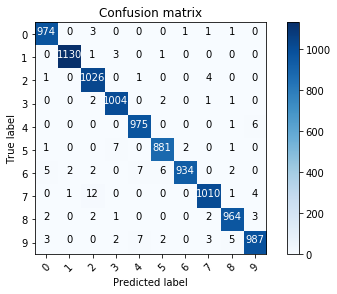

In [75]:
pred_all = output_all.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
# compute the confusion matrix
confusion_mtx = confusion_matrix(target_all, pred_all) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Plot All Failures

6 failures for digit 0
Classification: [6 2 7 8 2 2]
Labels: [0 0 0 0 0 0]


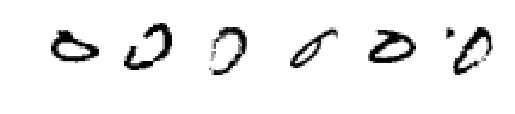

5 failures for digit 1
Classification: [3 3 2 3 5]
Labels: [1 1 1 1 1]


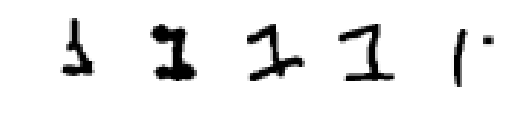

6 failures for digit 2
Classification: [7 0 7 4 7 7]
Labels: [2 2 2 2 2 2]


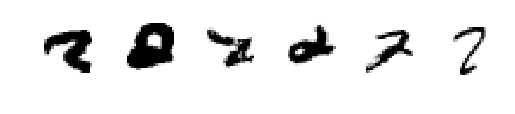

6 failures for digit 3
Classification: [5 7 2 2 5 8]
Labels: [3 3 3 3 3 3]


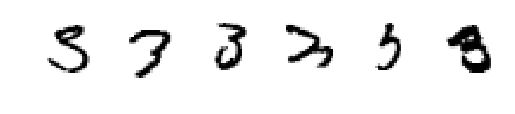

7 failures for digit 4
Classification: [9 9 8 9 9 9 9]
Labels: [4 4 4 4 4 4 4]


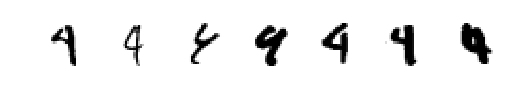

11 failures for digit 5
Classification: [3 3 3 3 3 0 8 3 3 6 6]
Labels: [5 5 5 5 5 5 5 5 5 5 5]


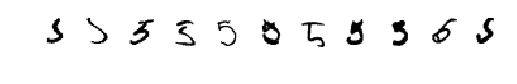

24 failures for digit 6
Classification: [5 0 0 0 5 5 4 4 1 5 1 0 0 4 5 5 4 8 4 2 4 4 2 8]
Labels: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


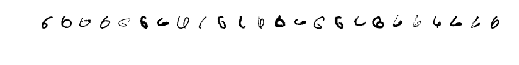

18 failures for digit 7
Classification: [9 2 2 2 9 2 2 9 9 2 2 8 2 1 2 2 2 2]
Labels: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


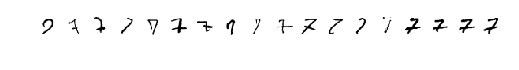

10 failures for digit 8
Classification: [2 9 7 3 0 0 7 9 9 2]
Labels: [8 8 8 8 8 8 8 8 8 8]


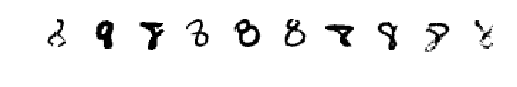

22 failures for digit 9
Classification: [4 4 5 4 3 4 8 8 0 0 8 4 5 7 4 3 8 8 0 7 4 7]
Labels: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


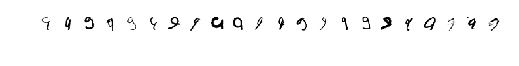

In [80]:
target_failures = target_all[failure_indices]

failure_idx_by_digit = list(map(lambda digit: np.where(target_failures.eq(digit))[0], range(0,10)))

for digit in range(0,10):
    fail_idx = failure_indices[failure_idx_by_digit[digit]]
    print('{} failures for digit {}'.format(fail_idx.size, digit))
    output = output_all[fail_idx].argmax(dim=1, keepdim=True).numpy().T[0]
    print('Classification: {}'.format(output))
    plot_data(test_loader.dataset, fail_idx)

In [110]:
def plot_kernels(conv_layer):
    out_dim = conv_layer.size()[0]
    in_dim = conv_layer.size()[1]
    kw = conv_layer.size()[2]
    kh = conv_layer.size()[3]
    #np.linalg.svd()

    for row in range(0,out_dim):
        fig, ax = plt.subplots(1, in_dim, dpi=200)
        for col in range(0,in_dim):
            if in_dim>1:
                col_ax = ax[col]
            else:
                col_ax = ax
            col_ax.imshow(conv_layer[row][col].numpy(), cmap='binary')
            col_ax.axis('off')
        plt.show()

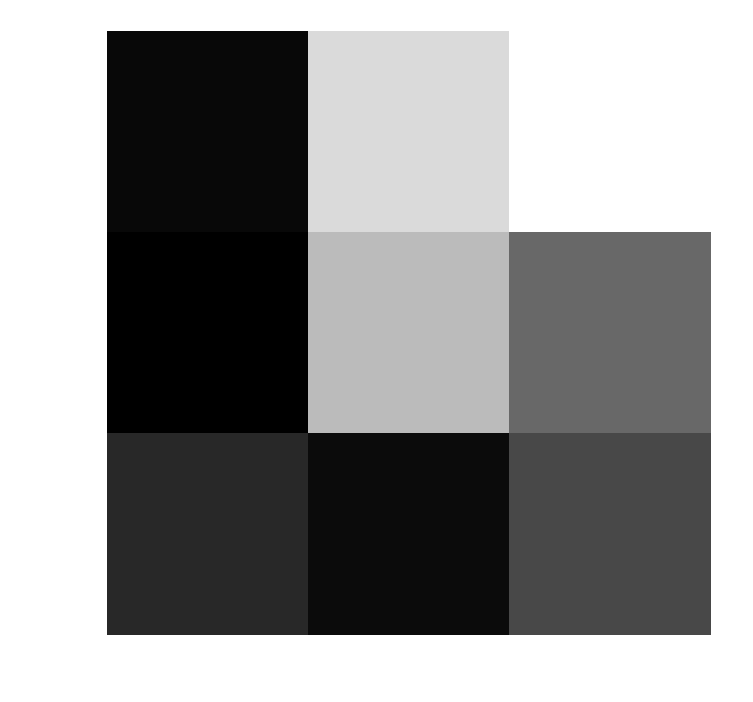

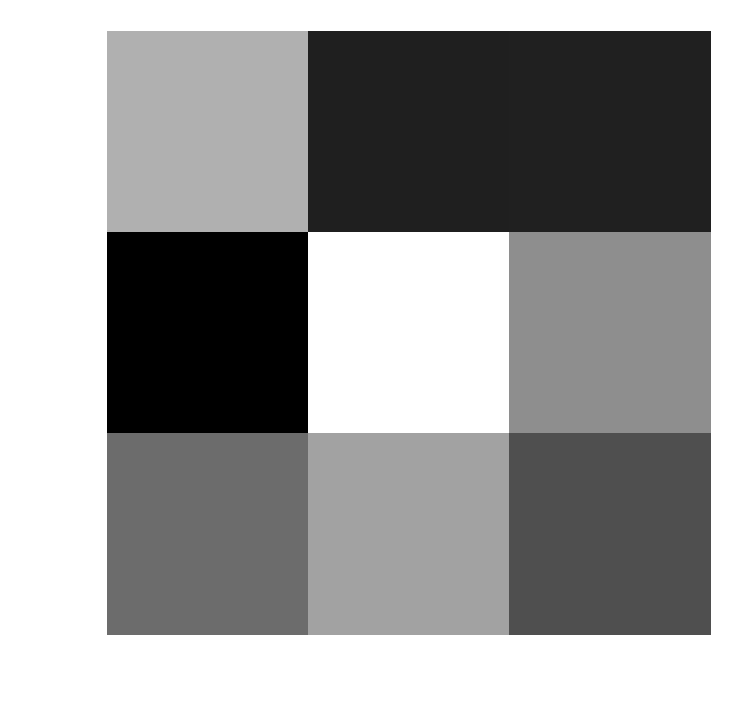

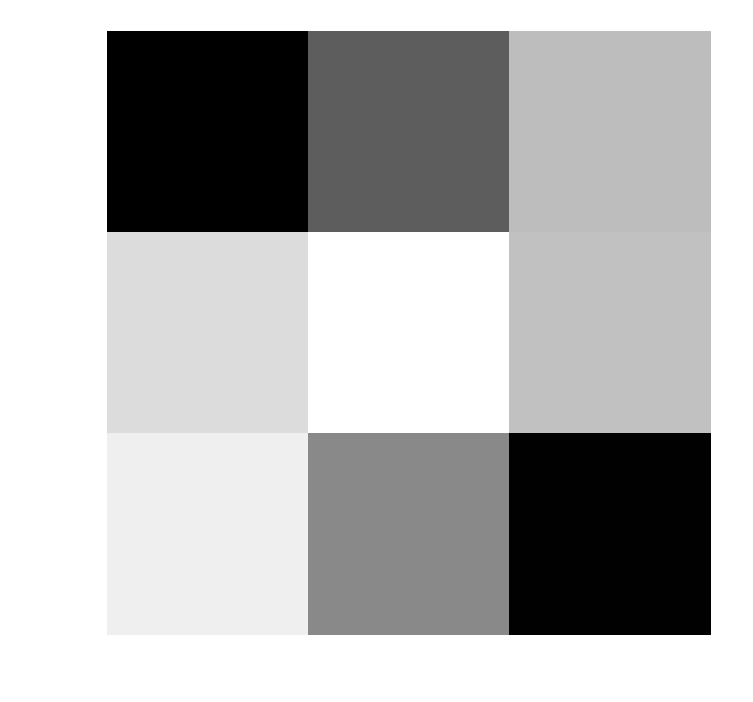

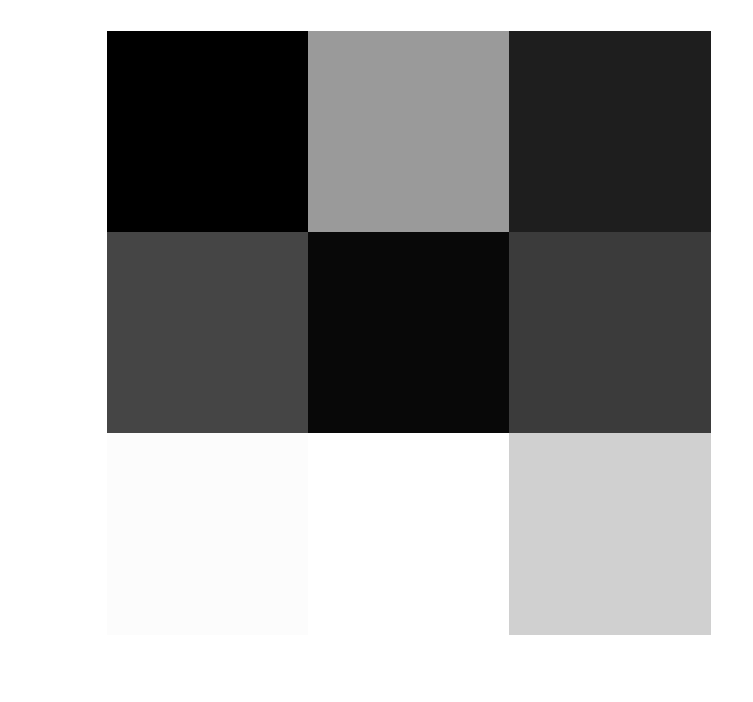

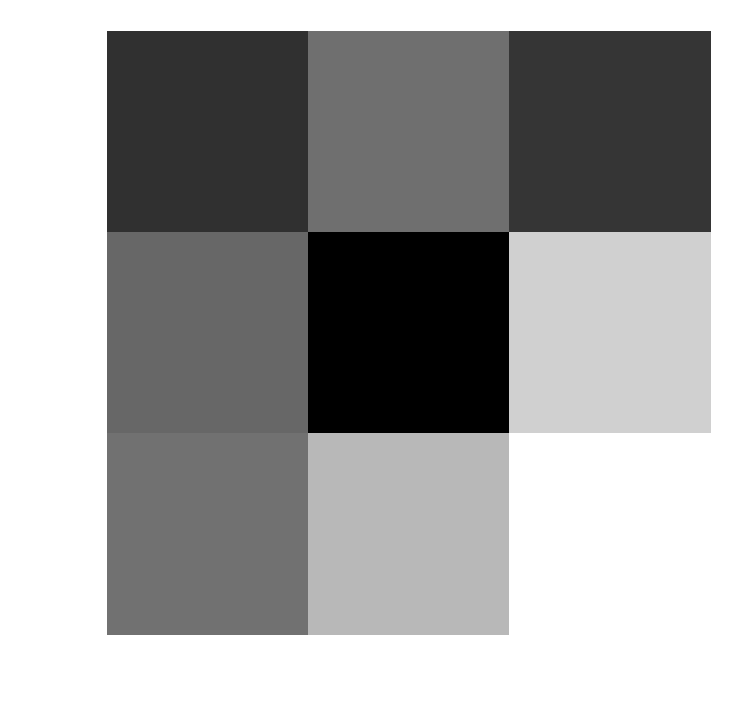

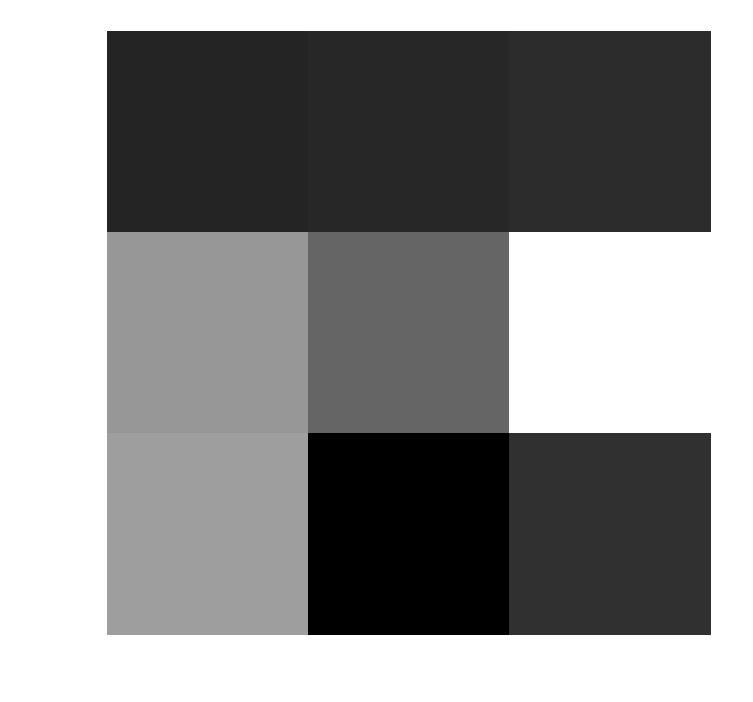

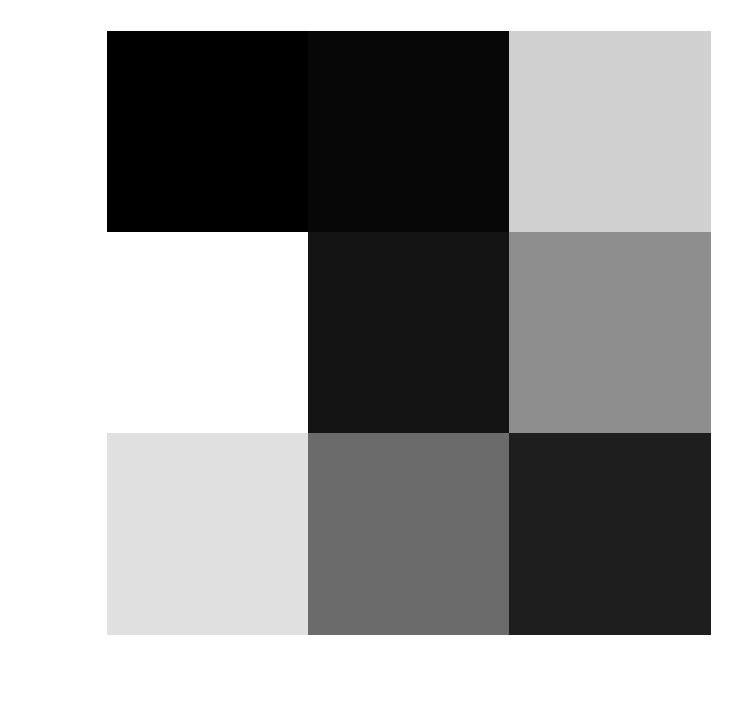

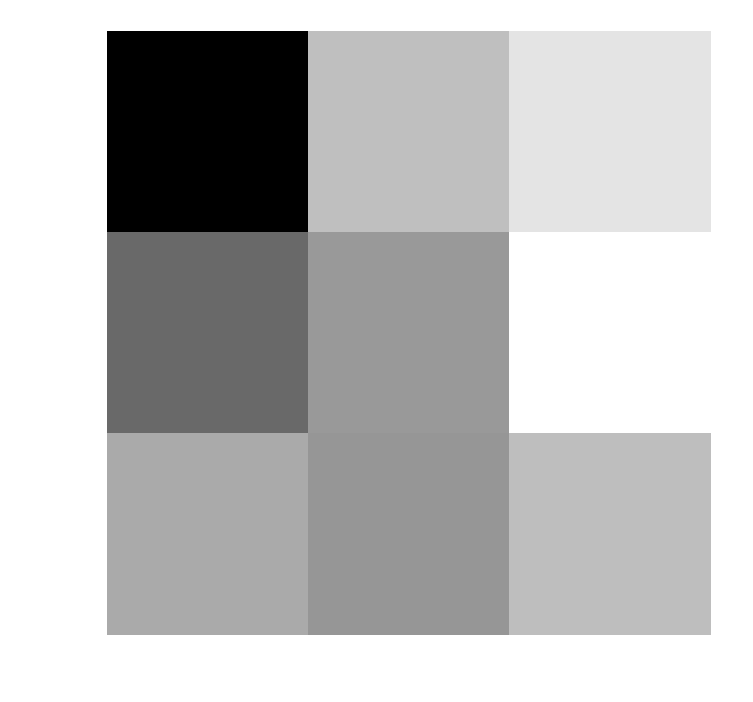

In [111]:
plot_kernels(model.state_dict()['conv1.weight'])

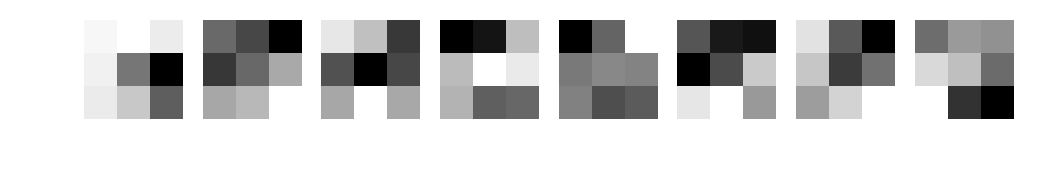

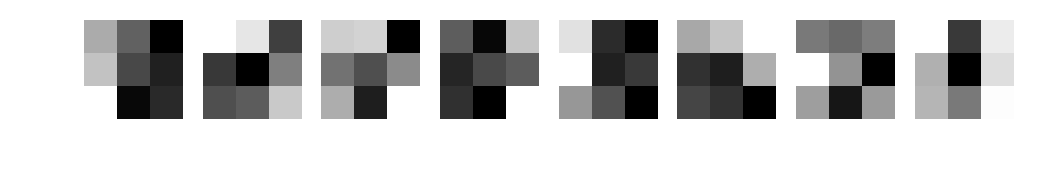

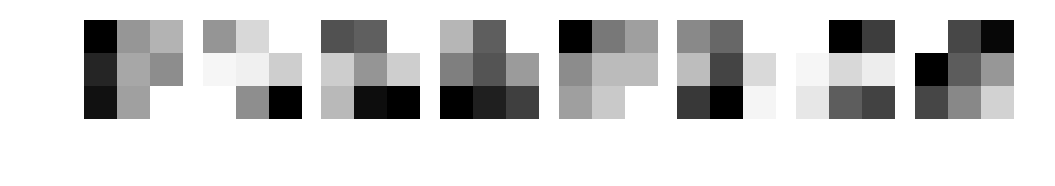

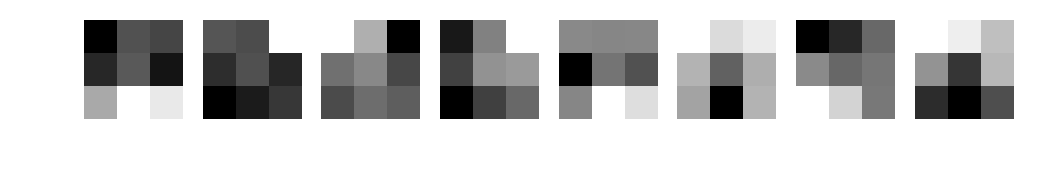

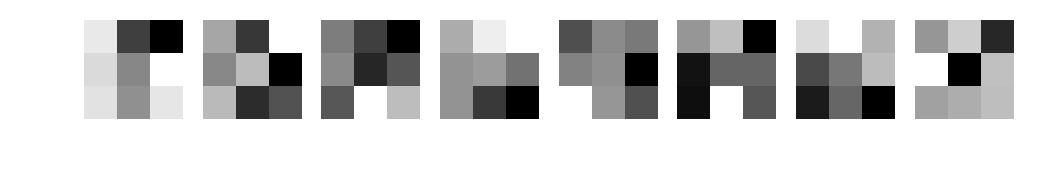

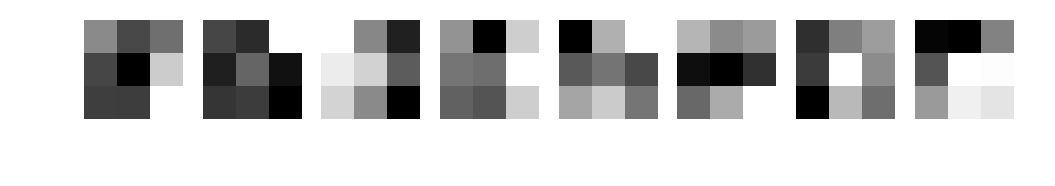

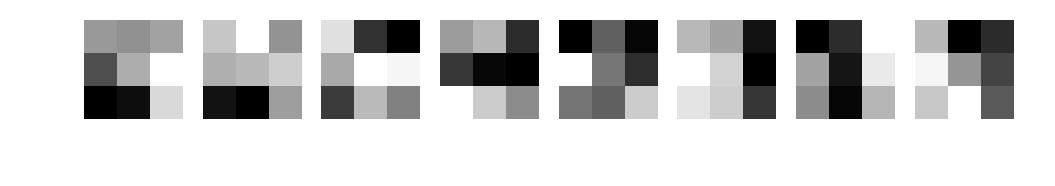

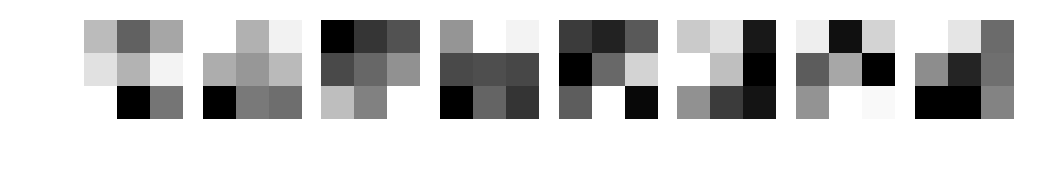

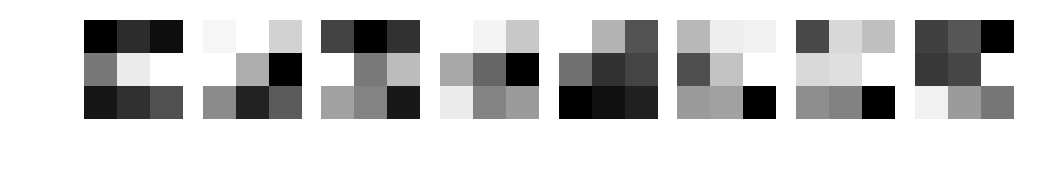

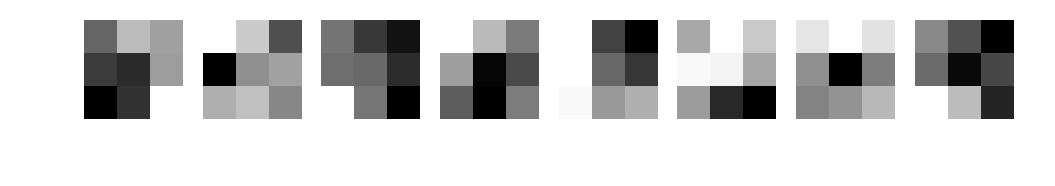

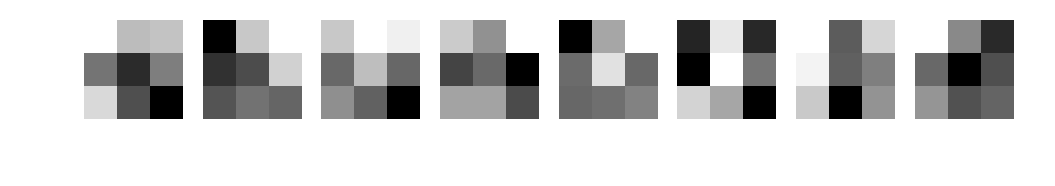

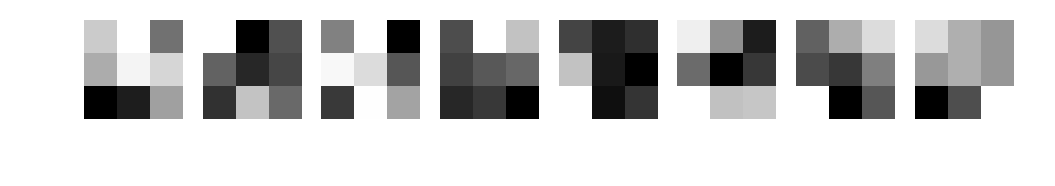

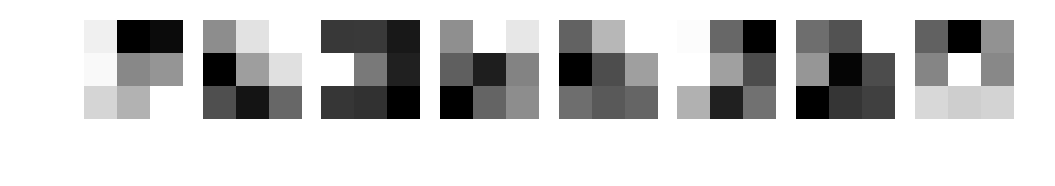

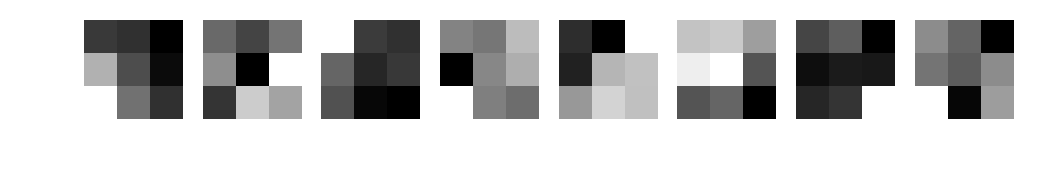

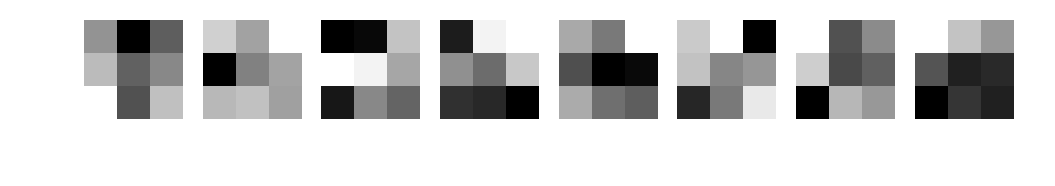

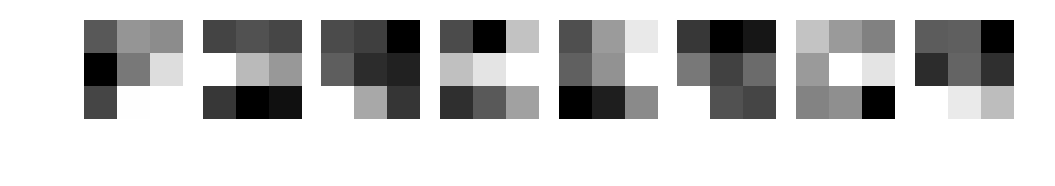

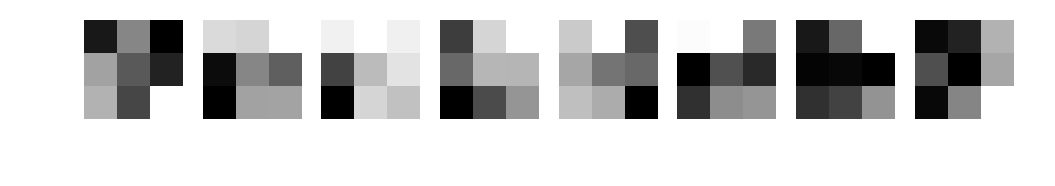

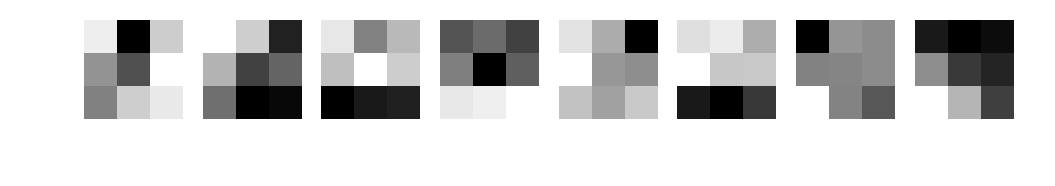

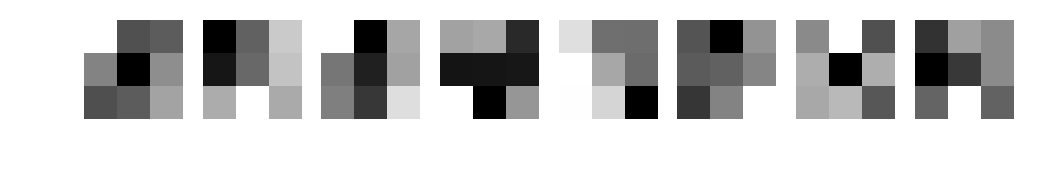

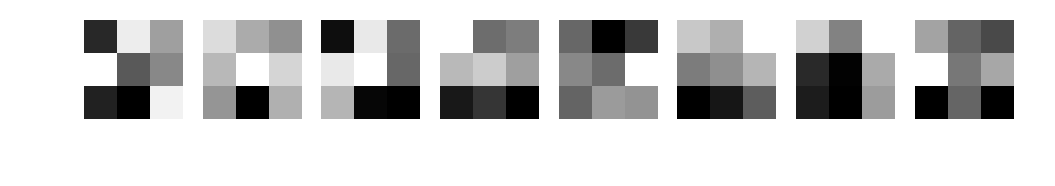

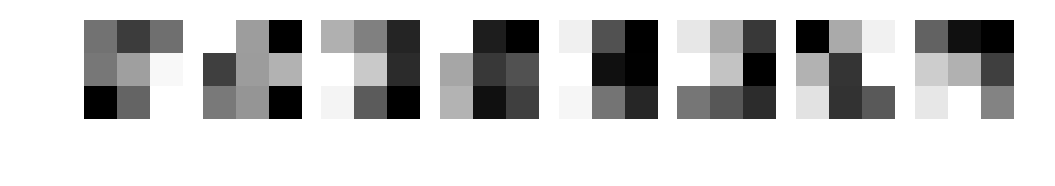

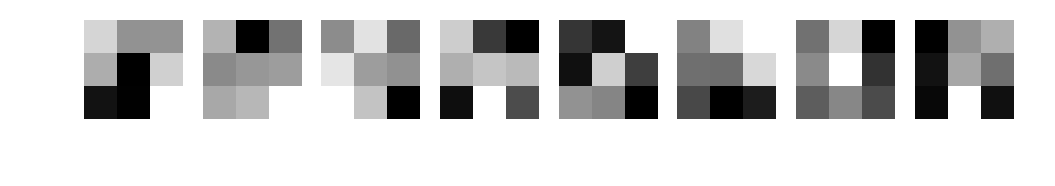

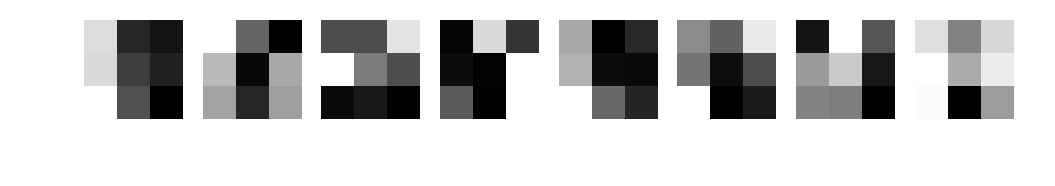

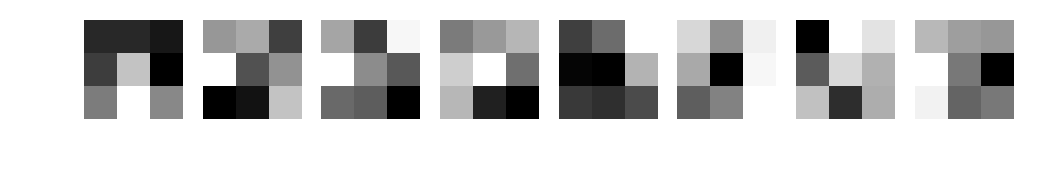

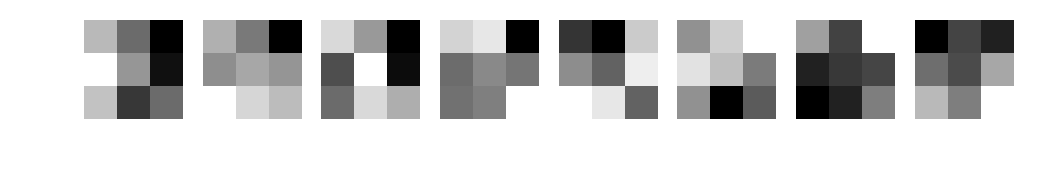

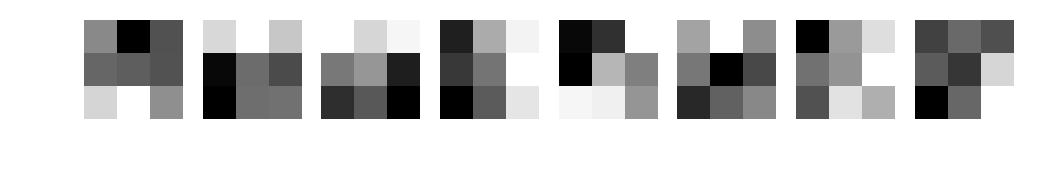

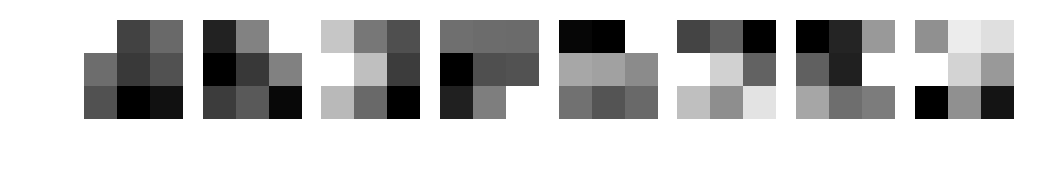

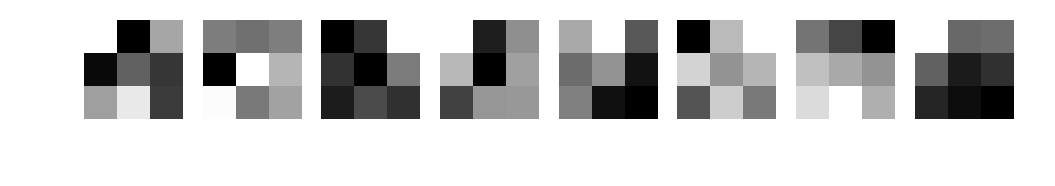

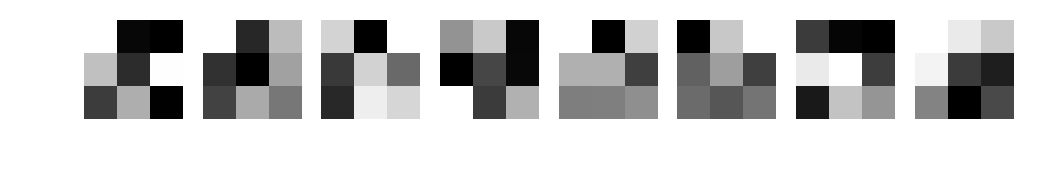

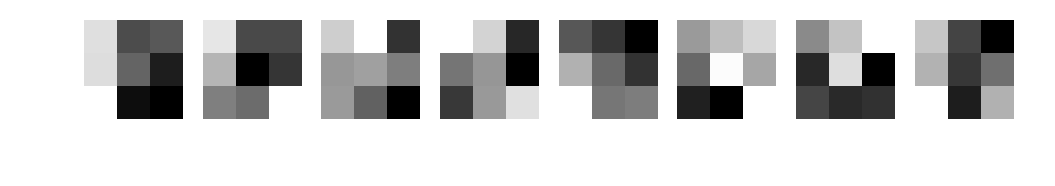

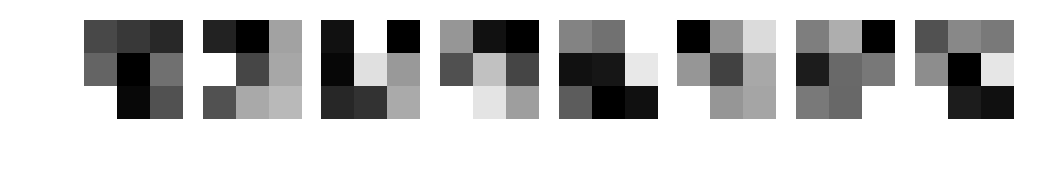

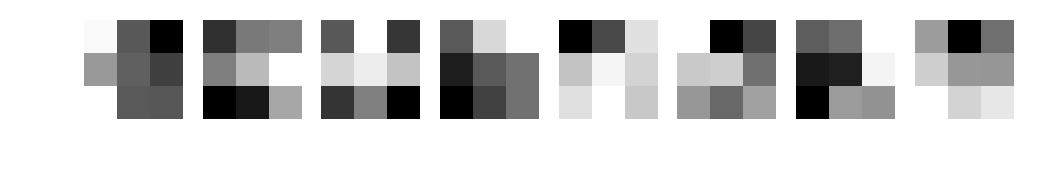

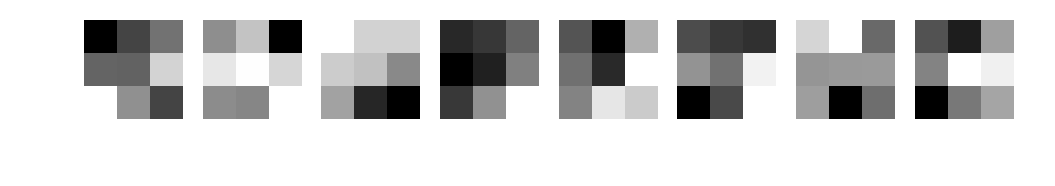

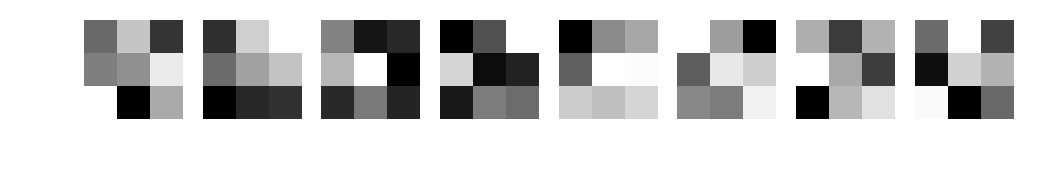

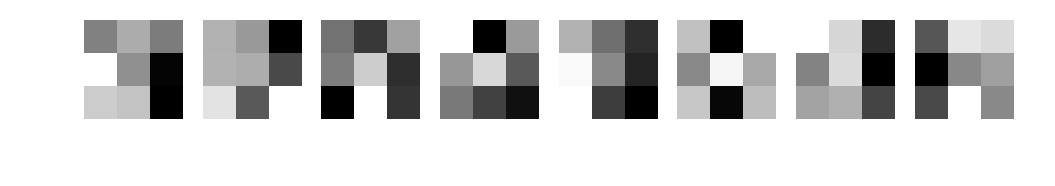

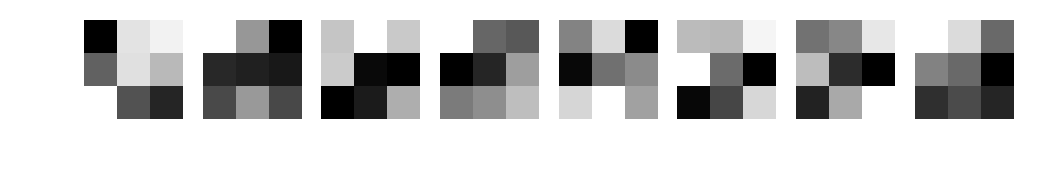

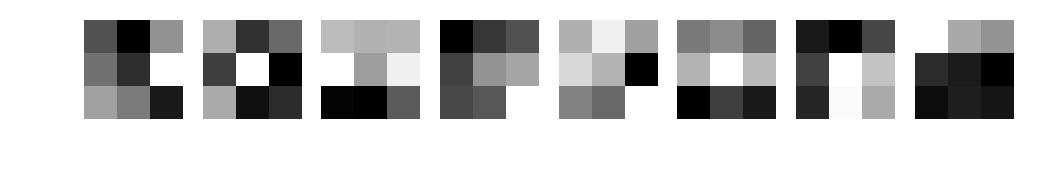

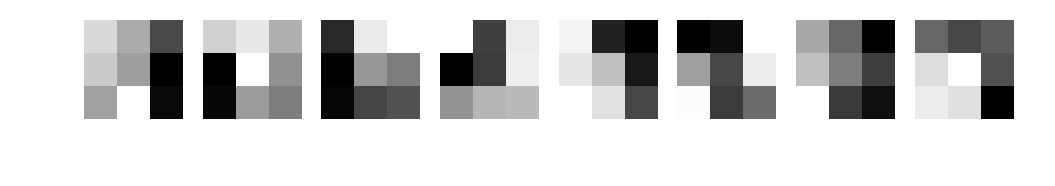

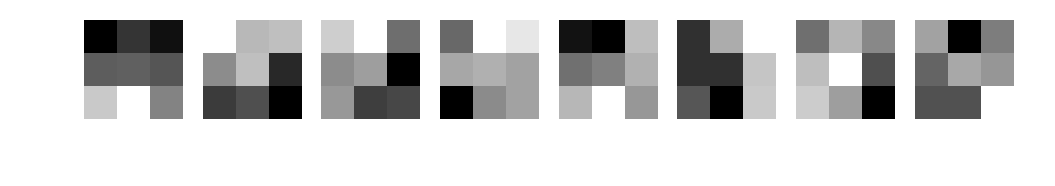

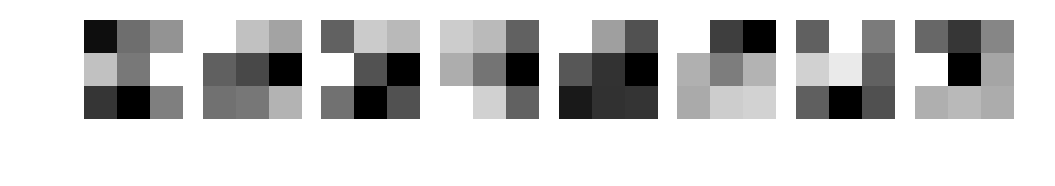

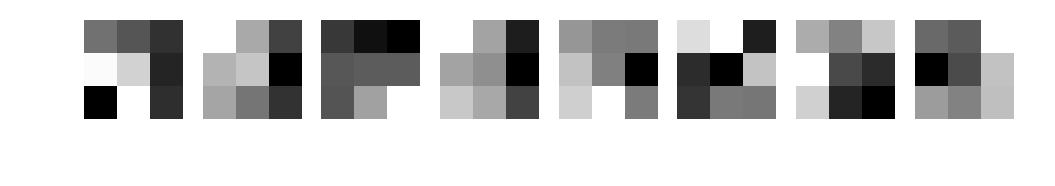

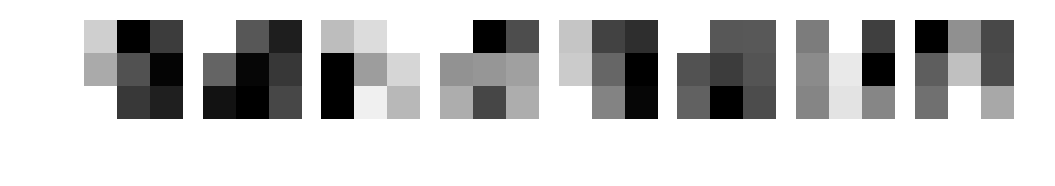

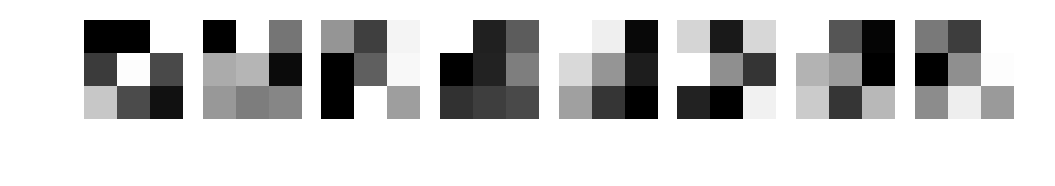

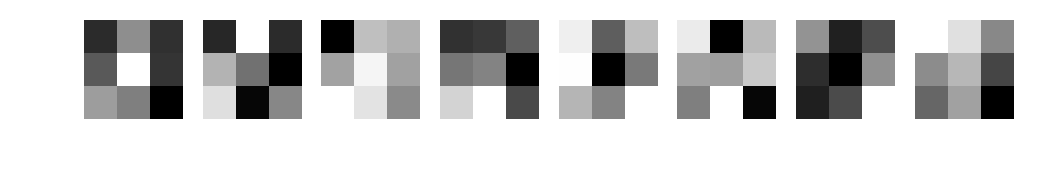

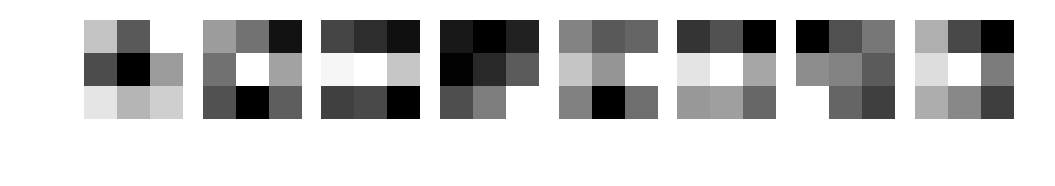

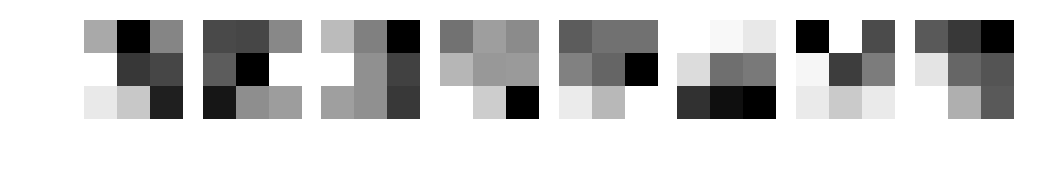

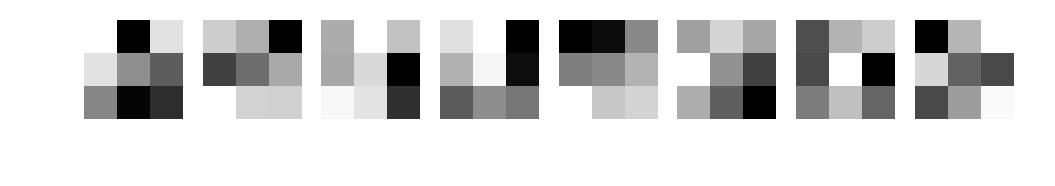

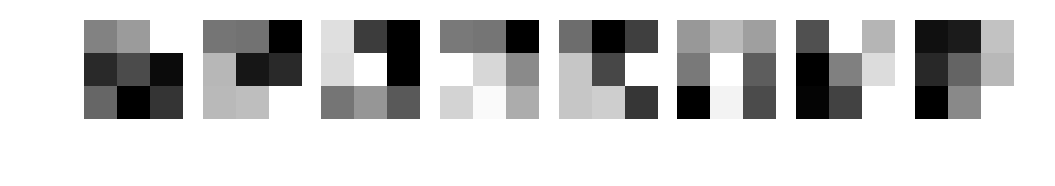

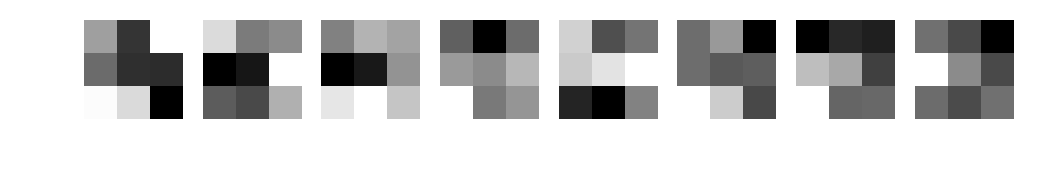

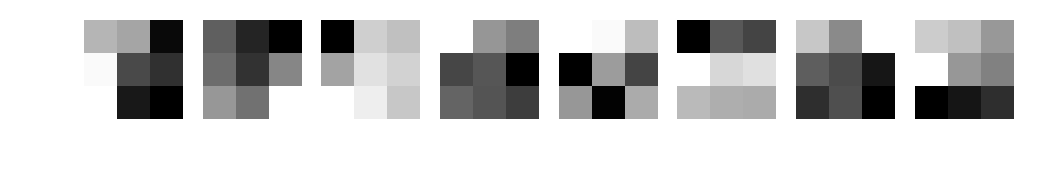

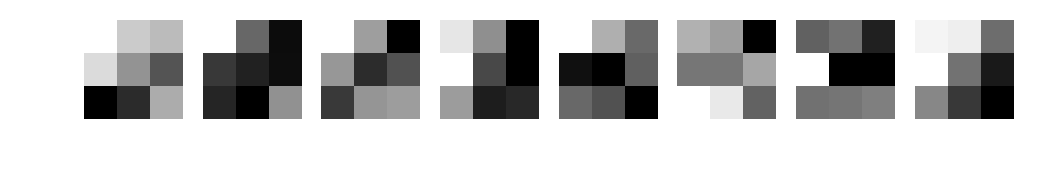

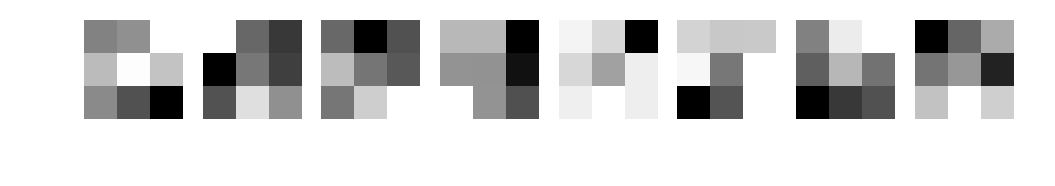

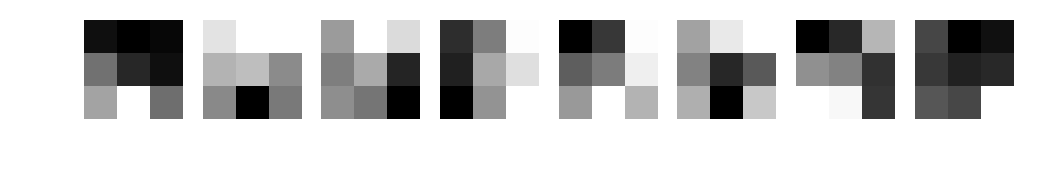

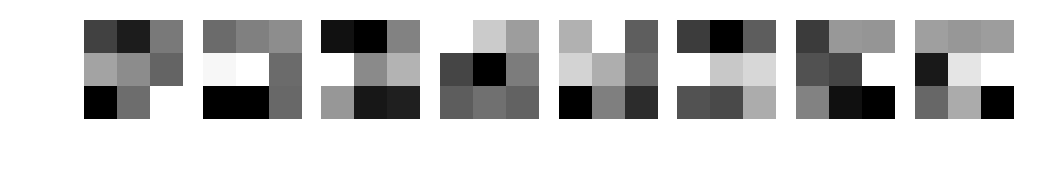

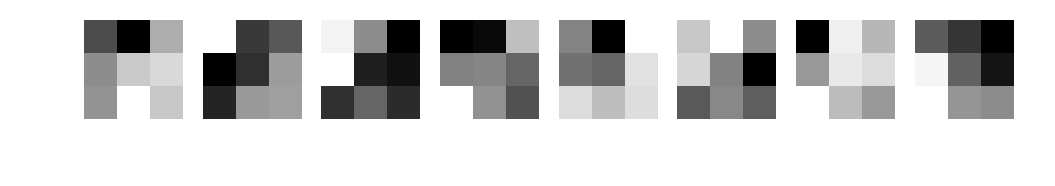

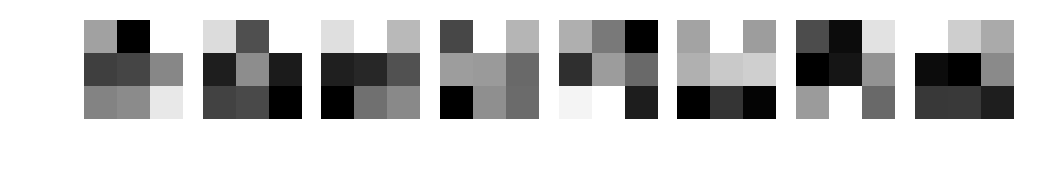

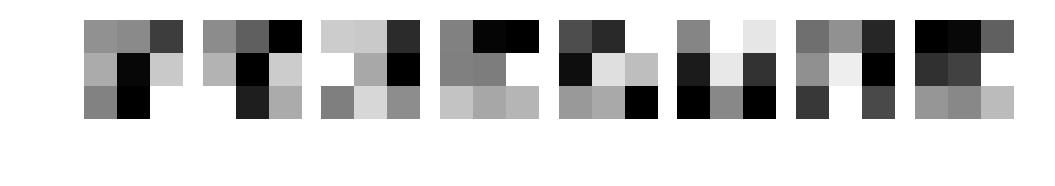

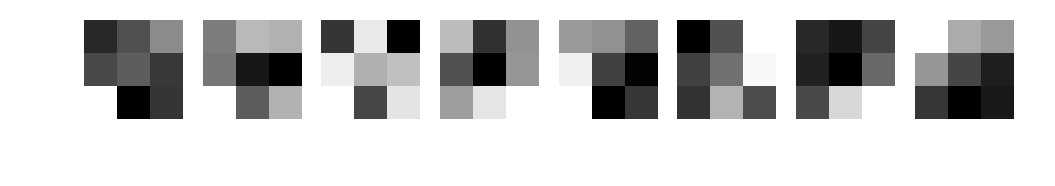

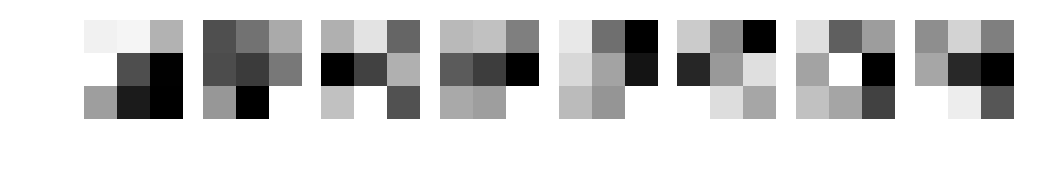

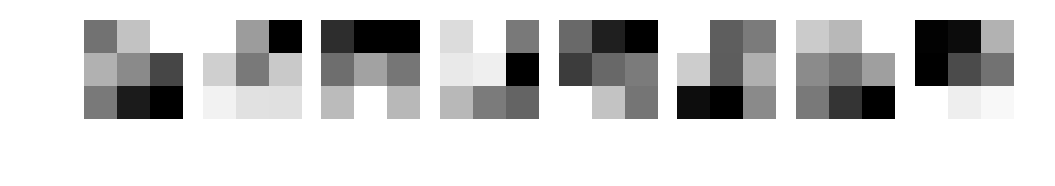

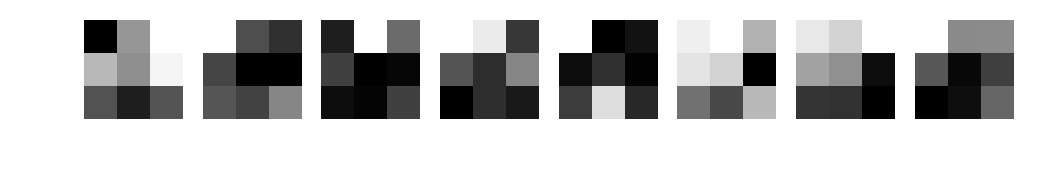

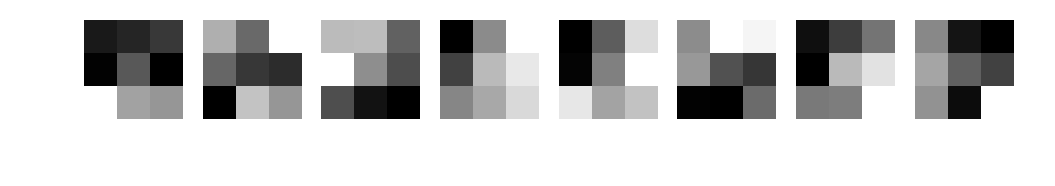

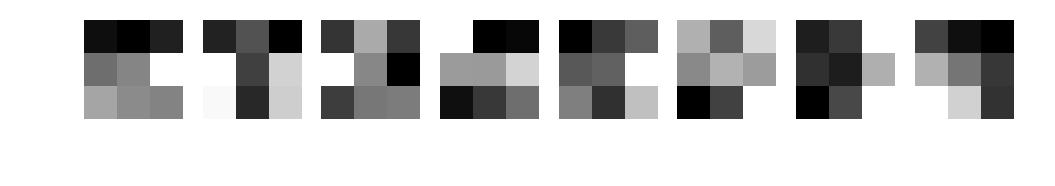

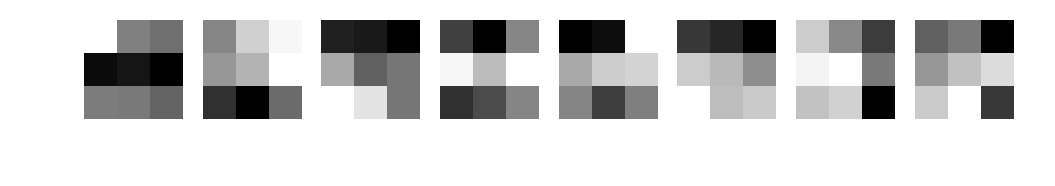

In [112]:
plot_kernels(model.state_dict()['conv2.weight'])